# General Outline
My idea for our game recommendation system is that we will input the title of some game available on Steam, and the system will output titles that are (hopefully!) very similar to it. On a technical level, we'll use and manipulate a DataFrame constructed from one of the provided CSV files to train a k-means clustering system. By inputting the title, we'll search for the title in the DataFrame, then obtain its cluster label, and get other titles within that same cluster and return the ones that are the most similar. 

Progress workflow:
1. transform the steam.csv dataframe values into numerical ones for clustering purposes (e.g. one-hot, binary encoding, etc.). also need to run basic EDA and data cleaning stuff like checking nan values
2. determine the best k for clustering, using the elbow method for transparency and to provide a visualization. best k probably depends mainly on genre, so it might be in the 20-40 range
3. run clustering using a set random state to ensure the same clusters every time; append the values to the dataframe for search purposes; visualize the clusters
4. create a title search method for fun interactivity :)

# 1. Exploration, Data Cleaning

The downloadable archive.zip file from [Kaggle](https://www.kaggle.com/nikdavis/steam-store-games?select=steamspy_tag_data.csv) contains 6 different CSV files. Upon inspection of all of the columns in each file, I determined that only the 'steam.csv' file is useful because it contains the majority of the data that we're looking for, such as genres, release dates, and languages. The only other semi-useful file is the 'steamspy_tag_data.csv', but the features listed in those are of negligible importance compared to the information in 'steam.csv.' 

In [2]:
from google.colab import files
files.upload();

Saving steam.csv to steam.csv


In [ ]:
import pandas as pd
import numpy as np

steam = pd.read_csv('steam.csv')
steam.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


In [ ]:
steam.isna().sum()

appid               0
name                0
release_date        0
english             0
developer           0
publisher           0
platforms           0
required_age        0
categories          0
genres              0
steamspy_tags       0
achievements        0
positive_ratings    0
negative_ratings    0
average_playtime    0
median_playtime     0
owners              0
price               0
dtype: int64

Surprisingly, there are no NaN values! This is nice because it makes data cleaning much easier and also ensures that our recommendations list is as big as possible since we don't have to remove instances.

Now, I'd like to investigate the game descriptor columns because those will be instrumental in our model.

In [ ]:
np.unique(steam['genres'])

array(['Accounting;Animation & Modeling;Audio Production;Design & Illustration;Education;Photo Editing;Software Training;Utilities;Video Production;Web Publishing',
       'Accounting;Education;Software Training;Utilities;Early Access',
       'Action', ..., 'Violent;Sports', 'Violent;Strategy',
       'Web Publishing'], dtype=object)

In [ ]:
np.unique(steam['steamspy_tags'])

array(['1980s;Great Soundtrack;Retro', "1990's;Simulation;Point & Click",
       '2D Fighter;Action;Fighting', ..., 'Zombies;Survival;RPG',
       'Zombies;VR;Horror', 'Zombies;World War II;FPS'], dtype=object)

In [ ]:
np.unique(steam['categories'])

array(['Captions available',
       'Captions available;Steam Cloud;Includes level editor',
       'Co-op;Local Co-op;Shared/Split Screen;Steam Achievements;Full controller support',
       ..., 'VR Support;Partial Controller Support',
       'VR Support;Steam Workshop', 'VR Support;SteamVR Collectibles'],
      dtype=object)

Just from looking at the values in the genres, steamspy_tags, and categories columns, it seems that there's a lot of overlap. I think that our model would benefit most from treating all three columns like a list of tags, and simply concatenating them so that we can use str.get_dummies to binary-encode the different tags. Thankfully, str.get_dummies also removes duplicate values, which should greatly reduce the number of potential redundant columns (e.g. the 'Action' tag, which is often duplicated).

In [ ]:
#concatenating the 3 columns with a semi-colon delimiter since that's the delimiter used throughout the dataset
steam['tags'] = steam['genres'] + ';' + steam['steamspy_tags'] + ';' + steam['categories']
steam = steam.drop(columns=['categories', 'genres', 'steamspy_tags'])
steam.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,tags
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,0,124534,3339,17612,317,10000000-20000000,7.19,Action;Action;FPS;Multiplayer;Multi-player;Onl...
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,0,3318,633,277,62,5000000-10000000,3.99,Action;Action;FPS;Multiplayer;Multi-player;Onl...
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,0,3416,398,187,34,5000000-10000000,3.99,Action;FPS;World War II;Multiplayer;Multi-play...
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,0,1273,267,258,184,5000000-10000000,3.99,Action;Action;FPS;Multiplayer;Multi-player;Onl...
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,0,5250,288,624,415,5000000-10000000,3.99,Action;FPS;Action;Sci-fi;Single-player;Multi-p...


In [ ]:
steam_tags = steam['tags'].str.get_dummies(';')
steam_tags.head()

,1980s,1990's,2.5D,2D,2D Fighter,360 Video,3D,3D Platformer,3D Vision,4 Player Local,4X,6DOF,Abstract,Accounting,Action,Action RPG,Action-Adventure,Adventure,Agriculture,Aliens,Alternate History,America,Animation & Modeling,Anime,Arcade,Arena Shooter,Assassin,Atmospheric,Audio Production,BMX,Base-Building,Baseball,Basketball,Batman,Battle Royale,Beat 'em up,Beautiful,Benchmark,Bikes,Blood,...,Top-Down,Top-Down Shooter,Touch-Friendly,Tower Defense,Trading,Trading Card Game,Trains,Turn-Based,Turn-Based Combat,Turn-Based Strategy,Turn-Based Tactics,Tutorial,Twin Stick Shooter,Typing,Underwater,Utilities,VR,VR Only,VR Support,Valve Anti-Cheat enabled,Vampire,Video Production,Villain Protagonist,Violent,Visual Novel,Voice Control,Voxel,Walking Simulator,War,Wargame,Warhammer 40K,Web Publishing,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,e-sports
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#joining the two datasets, dropping the original tags column since we have all the tags as dummy columns
steam = steam.join(steam_tags)
steam = steam.drop(columns=['tags'])
steam.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,1980s,1990's,2.5D,2D,2D Fighter,360 Video,3D,3D Platformer,3D Vision,4 Player Local,4X,6DOF,Abstract,Accounting,Action,Action RPG,Action-Adventure,Adventure,Agriculture,Aliens,Alternate History,America,Animation & Modeling,Anime,Arcade,...,Top-Down,Top-Down Shooter,Touch-Friendly,Tower Defense,Trading,Trading Card Game,Trains,Turn-Based,Turn-Based Combat,Turn-Based Strategy,Turn-Based Tactics,Tutorial,Twin Stick Shooter,Typing,Underwater,Utilities,VR,VR Only,VR Support,Valve Anti-Cheat enabled,Vampire,Video Production,Villain Protagonist,Violent,Visual Novel,Voice Control,Voxel,Walking Simulator,War,Wargame,Warhammer 40K,Web Publishing,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,e-sports
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,0,124534,3339,17612,317,10000000-20000000,7.19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,0,3318,633,277,62,5000000-10000000,3.99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,0,3416,398,187,34,5000000-10000000,3.99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,0,1273,267,258,184,5000000-10000000,3.99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,0,5250,288,624,415,5000000-10000000,3.99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Next, I'll do the same thing for the platforms column, because it's a useful feature that dictates accessibility to other games.

In [ ]:
np.unique(steam['platforms'])

array(['linux', 'mac', 'mac;linux', 'windows', 'windows;linux',
       'windows;mac', 'windows;mac;linux'], dtype=object)

In [ ]:
print("'linux' in dataframe columns: ", ('linux' in steam.columns))
print("'windows' in dataframe columns: ", ('windows' in steam.columns))
print("'mac' in dataframe columns: ", ('mac' in steam.columns))

'linux' in dataframe columns:  False
'windows' in dataframe columns:  False
'mac' in dataframe columns:  False


 The unique values in the platforms column don't appear anywhere else in the index, so this is also safe to get dummy variables for.

In [ ]:
steam_platforms = steam['platforms'].str.get_dummies(';')
steam = steam.join(steam_platforms)
steam = steam.drop(columns=['platforms'])
steam.head()

,appid,name,release_date,english,developer,publisher,required_age,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,1980s,1990's,2.5D,2D,2D Fighter,360 Video,3D,3D Platformer,3D Vision,4 Player Local,4X,6DOF,Abstract,Accounting,Action,Action RPG,Action-Adventure,Adventure,Agriculture,Aliens,Alternate History,America,Animation & Modeling,Anime,Arcade,Arena Shooter,...,Tower Defense,Trading,Trading Card Game,Trains,Turn-Based,Turn-Based Combat,Turn-Based Strategy,Turn-Based Tactics,Tutorial,Twin Stick Shooter,Typing,Underwater,Utilities,VR,VR Only,VR Support,Valve Anti-Cheat enabled,Vampire,Video Production,Villain Protagonist,Violent,Visual Novel,Voice Control,Voxel,Walking Simulator,War,Wargame,Warhammer 40K,Web Publishing,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,e-sports,linux,mac,windows
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,0,0,124534,3339,17612,317,10000000-20000000,7.19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,0,0,3318,633,277,62,5000000-10000000,3.99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,0,0,3416,398,187,34,5000000-10000000,3.99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,0,0,1273,267,258,184,5000000-10000000,3.99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,0,0,5250,288,624,415,5000000-10000000,3.99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1


Now, I'd like to do a little manipulation on some of the numerical variables.

I think it'd be more useful and concise to have an approval rating as a proportion instead of two separate columns for positive and negative ratings, so I'll change that first. However, since small total numbers of reviews can skew an approval rating, I think it would also be prudent to add a column containing the total number of ratings. 

**However:** it's worth noting that because of the nature of clustering, games will probably have similar ratings within clusters. If a title with a pretty low approval rating is provided, then the clustering algorithm might recommend similarly poorly-rated games, which isn't exactly ideal. I think this is a risk we might just have to take because while this is a pretty important aspect, there are also hundreds of other features that the clustering algorithm will take into account.

In [ ]:
steam['approval_rating'] = steam['positive_ratings'] / (steam['positive_ratings'] + steam['negative_ratings'])
steam['total_ratings'] = (steam['positive_ratings'] + steam['negative_ratings'])
steam = steam.drop(columns=['positive_ratings', 'negative_ratings'])
steam.head()

,appid,name,release_date,english,developer,publisher,required_age,achievements,average_playtime,median_playtime,owners,price,1980s,1990's,2.5D,2D,2D Fighter,360 Video,3D,3D Platformer,3D Vision,4 Player Local,4X,6DOF,Abstract,Accounting,Action,Action RPG,Action-Adventure,Adventure,Agriculture,Aliens,Alternate History,America,Animation & Modeling,Anime,Arcade,Arena Shooter,Assassin,Atmospheric,...,Trading Card Game,Trains,Turn-Based,Turn-Based Combat,Turn-Based Strategy,Turn-Based Tactics,Tutorial,Twin Stick Shooter,Typing,Underwater,Utilities,VR,VR Only,VR Support,Valve Anti-Cheat enabled,Vampire,Video Production,Villain Protagonist,Violent,Visual Novel,Voice Control,Voxel,Walking Simulator,War,Wargame,Warhammer 40K,Web Publishing,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,e-sports,linux,mac,windows,approval_rating,total_ratings
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,0,0,17612,317,10000000-20000000,7.19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0.973888,127873
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,0,0,277,62,5000000-10000000,3.99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0.839787,3951
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,0,0,187,34,5000000-10000000,3.99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0.895648,3814
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,0,0,258,184,5000000-10000000,3.99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0.826623,1540
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,0,0,624,415,5000000-10000000,3.99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0.947996,5538


Instead of having the release_date variable, I want to get an "age" variable for each title. 

In [ ]:
now = pd.Timestamp('now')
steam['age'] = (now - pd.to_datetime(steam['release_date'])).astype('<m8[Y]')
steam = steam.drop(columns=['release_date'])
steam.head()

,appid,name,english,developer,publisher,required_age,achievements,average_playtime,median_playtime,owners,price,1980s,1990's,2.5D,2D,2D Fighter,360 Video,3D,3D Platformer,3D Vision,4 Player Local,4X,6DOF,Abstract,Accounting,Action,Action RPG,Action-Adventure,Adventure,Agriculture,Aliens,Alternate History,America,Animation & Modeling,Anime,Arcade,Arena Shooter,Assassin,Atmospheric,Audio Production,...,Trains,Turn-Based,Turn-Based Combat,Turn-Based Strategy,Turn-Based Tactics,Tutorial,Twin Stick Shooter,Typing,Underwater,Utilities,VR,VR Only,VR Support,Valve Anti-Cheat enabled,Vampire,Video Production,Villain Protagonist,Violent,Visual Novel,Voice Control,Voxel,Walking Simulator,War,Wargame,Warhammer 40K,Web Publishing,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,e-sports,linux,mac,windows,approval_rating,total_ratings,age
0,10,Counter-Strike,1,Valve,Valve,0,0,17612,317,10000000-20000000,7.19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0.973888,127873,21.0
1,20,Team Fortress Classic,1,Valve,Valve,0,0,277,62,5000000-10000000,3.99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0.839787,3951,22.0
2,30,Day of Defeat,1,Valve,Valve,0,0,187,34,5000000-10000000,3.99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0.895648,3814,18.0
3,40,Deathmatch Classic,1,Valve,Valve,0,0,258,184,5000000-10000000,3.99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0.826623,1540,20.0
4,50,Half-Life: Opposing Force,1,Gearbox Software,Valve,0,0,624,415,5000000-10000000,3.99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0.947996,5538,22.0


As for the rest of the columns, I may choose to drop some of them depending on how relevant I think they are, with explanations.


*   'appid': not useful; this is just a unique identifier for each game so it doesn't make sense to cluster based on this
*   'developer' / 'publisher': 'developer' is probably more useful because developer studios are directly responsible for the actual style and content of the game, whereas publishers are merely that. I'll drop 'publisher' and get dummy variables for 'developer' because some games have multiple developers listed, and players may enjoy other titles by the same developer
    *   UPDATE: I attempted to get the dummy variables for all developers and I ran out of RAM... so I guess this isn't a feasible feature
*   'required_age': I checked the description of this on Kaggle and there's an overwhelming majority of 0's, which are said to also encapsulate unrated or not-provided age restrictions, so I'll remove this column
*   'achievements': I suspect this may not be accurate because games like 'Counter-Strike' have 0 achievements, which I know isn't correct, so I'll also remove this column
*   'average_playtime' / 'median_playtime': averages can be skewed by very large outliers, so I think it would be more informative to retain the median playtime instead
*   'owners': I don't think this is valuable because it mainly refers to game popularity, which might not be as big of a selling point as other genre-related features
*   'price': since the dataset was updated at least 2 years ago, I don't think this is a very valuable feature either, and Steam constantly has sales which might affect the price anyways



In [ ]:
steam = steam.drop(columns=['appid', 'developer', 'publisher', 'required_age', 'achievements', 'average_playtime', 'owners', 'price'])
steam.head()

,name,english,median_playtime,1980s,1990's,2.5D,2D,2D Fighter,360 Video,3D,3D Platformer,3D Vision,4 Player Local,4X,6DOF,Abstract,Accounting,Action,Action RPG,Action-Adventure,Adventure,Agriculture,Aliens,Alternate History,America,Animation & Modeling,Anime,Arcade,Arena Shooter,Assassin,Atmospheric,Audio Production,BMX,Base-Building,Baseball,Basketball,Batman,Battle Royale,Beat 'em up,Beautiful,...,Trains,Turn-Based,Turn-Based Combat,Turn-Based Strategy,Turn-Based Tactics,Tutorial,Twin Stick Shooter,Typing,Underwater,Utilities,VR,VR Only,VR Support,Valve Anti-Cheat enabled,Vampire,Video Production,Villain Protagonist,Violent,Visual Novel,Voice Control,Voxel,Walking Simulator,War,Wargame,Warhammer 40K,Web Publishing,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,e-sports,linux,mac,windows,approval_rating,total_ratings,age
0,Counter-Strike,1,317,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0.973888,127873,21.0
1,Team Fortress Classic,1,62,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0.839787,3951,22.0
2,Day of Defeat,1,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0.895648,3814,18.0
3,Deathmatch Classic,1,184,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0.826623,1540,20.0
4,Half-Life: Opposing Force,1,415,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0.947996,5538,22.0


This dataset looks much more usable now, at least from an algorithmic standpoint!

# 2. Finding the Best K for K-Means Clustering

For visualization purposes, I want to use the "sum of within cluster variance" metric along with the elbow method in order to determine the best value of k. 

In the elbow method, we run through a certain range of values for k and train a clustering model for each value of k, then calculate the sum of within-cluster variance (which evaluates the "goodness" of a clustering), and plot all of these values. The lower this sum is, the better the clustering, so the goal of this elbow method is to determine the k where the sum decreases the most, which we will then use for the optimal clustering (hence the name "elbow" method).

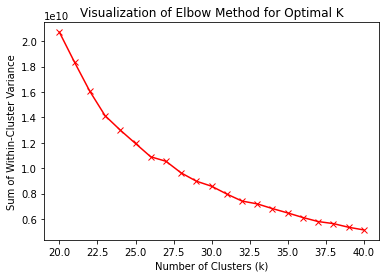

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

#the inertia attribute of a kmeans object is the sum of within cluster variance, so we'll store those in a list
#as I stated before, since there are so many games and genres, the ideal k may be in the 20-40 range (hopefully), so that's the range I'll test
sse = []
for k in range(20, 41):
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(steam.drop(columns=['name']))
  sum_var = kmeans.inertia_
  sse.append(sum_var)

#generating the elbow plot
plt.plot(range(20, 41), sse, 'rx-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Sum of Within-Cluster Variance")
plt.title("Visualization of Elbow Method for Optimal K")
plt.show()

It looks like there's a pretty good "elbow" at k = 23, and 23 seems like a reasonable number of clusters, so we'll use that for the clustering.

# 3. Finalizing and Visualizing the Clustering

Because our dataset has a much higher dimensionality than 3, we need to perform dimensionality reduction on it in order to visualize it. The methods that we used in lab 7 worked very well, so I'll follow those steps and use the same libraries to enable some interactivity and exploration of the clusters.

In [ ]:
#importing the necessary libraries
from sklearn.manifold import TSNE
from IPython.display import Image
from IPython.display import Javascript
!git clone https://github.com/CAHLR/d3-scatterplot.git

Cloning into 'd3-scatterplot'...
remote: Enumerating objects: 1045, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 1045 (delta 16), reused 0 (delta 0), pack-reused 1016
Receiving objects: 100% (1045/1045), 1.95 MiB | 12.04 MiB/s, done.
Resolving deltas: 100% (605/605), done.


In [ ]:
#getting finalized clustering and cluster labels
clustering = KMeans(n_clusters=23, random_state=42)
clustering.fit(steam.drop(columns=['name']))
cluster_labels = clustering.labels_

In [ ]:
#reducing from 300+ dimensions to 2, creating new dataset for visualization
reduced_df_features = TSNE(n_components=2, perplexity=50, method='barnes_hut', random_state=42).fit_transform(steam.drop(columns=['name']))
reduced_df = pd.DataFrame(reduced_df_features, columns=["x", "y"])
reduced_df['Title of Game'] = steam['name']
reduced_df['Cluster'] = cluster_labels
reduced_df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


,x,y,Title of Game,Cluster
0,-58.158710,-33.741035,Counter-Strike,15
1,-1.684426,-70.292419,Team Fortress Classic,21
2,-0.425291,-70.801407,Day of Defeat,21
3,57.414165,-32.478760,Deathmatch Classic,21
4,-12.683545,-68.182953,Half-Life: Opposing Force,12


In [ ]:
#saving the df to a file so d3-scatterplot can visualize it. the code for the visualization was taken straight from the lab 7 colab
reduced_df.to_csv('d3-scatterplot/steam_clusters.tsv', sep='\t', index=False)

def show_port(port, data_file, width=600, height=800):
  display(Javascript("""
  (async ()=>{
    fm = document.createElement('iframe')
    fm.src = await google.colab.kernel.proxyPort(%d) + '/index.html?dataset=%s'
    fm.width = '90%%'
    fm.height = '%d'
    fm.frameBorder = 0
    document.body.append(fm)
  })();
  """ % (port, data_file, height)))

port = 8000
data_file = 'steam_clusters.tsv'
height = 1400

get_ipython().system_raw('cd d3-scatterplot && python3 -m http.server %d &' % port) 
show_port(port, data_file, height)

<IPython.core.display.Javascript object>

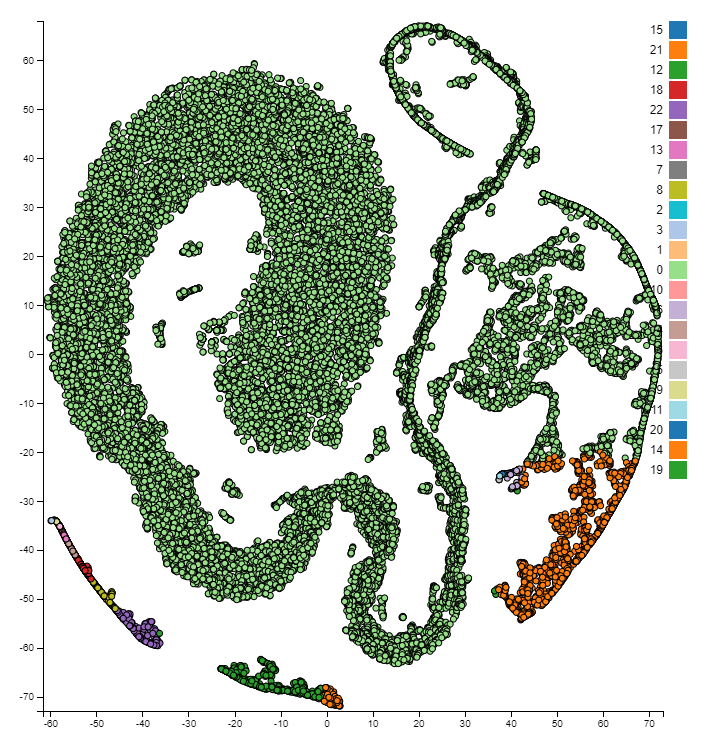

In [ ]:
Image('steamk=23.png')

These were the results of the initial k=23 clustering and the visualization of the reduced vectors. I'm both pleased and dissatisfied with this; I feel like the clusters should be much more distinct and spread out, but there is an overwhelming majority of instances belonging to cluster 0. However, inspection of some clusters (e.g. cluster 8, which contained titles like "Shadow of the Tomb Raider," "ABZU," "Wolfenstein II," and "Final Fantasy XV," which are all story-focused games) gave me some hope that there is coherency within clusters.

I plan to try again with higher values of k (perhaps even up to 50) just to see if we can further compartmentalize the instances belonging to cluster 0.

In [ ]:
#clustering once again with k = 50 this time
clustering_50 = KMeans(n_clusters=50, random_state=42)
clustering_50.fit(steam.drop(columns=['name']))
clustering_50_labels = clustering_50.labels_

In [ ]:
#dimensionality reduction + new df 
reduced_df_features_50 = TSNE(n_components=2, perplexity=50, method='barnes_hut', random_state=42).fit_transform(steam.drop(columns=['name']))
reduced_df_50 = pd.DataFrame(reduced_df_features_50, columns=["x", "y"])
reduced_df_50['Title of Game'] = steam['name']
reduced_df_50['Cluster'] = clustering_50_labels
reduced_df_50.head()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


,x,y,Title of Game,Cluster
0,-58.158710,-33.741035,Counter-Strike,10
1,-1.684426,-70.292419,Team Fortress Classic,28
2,-0.425291,-70.801407,Day of Defeat,28
3,57.414165,-32.478760,Deathmatch Classic,27
4,-12.683545,-68.182953,Half-Life: Opposing Force,9


In [ ]:
#visualization
reduced_df_50.to_csv('d3-scatterplot/steam_clusters_50.tsv', sep='\t', index=False)

def show_port(port, data_file, width=600, height=800):
  display(Javascript("""
  (async ()=>{
    fm = document.createElement('iframe')
    fm.src = await google.colab.kernel.proxyPort(%d) + '/index.html?dataset=%s'
    fm.width = '90%%'
    fm.height = '%d'
    fm.frameBorder = 0
    document.body.append(fm)
  })();
  """ % (port, data_file, height)))

port = 8000
data_file = 'steam_clusters_50.tsv'
height = 1400

get_ipython().system_raw('cd d3-scatterplot && python3 -m http.server %d &' % port) 
show_port(port, data_file, height)

<IPython.core.display.Javascript object>

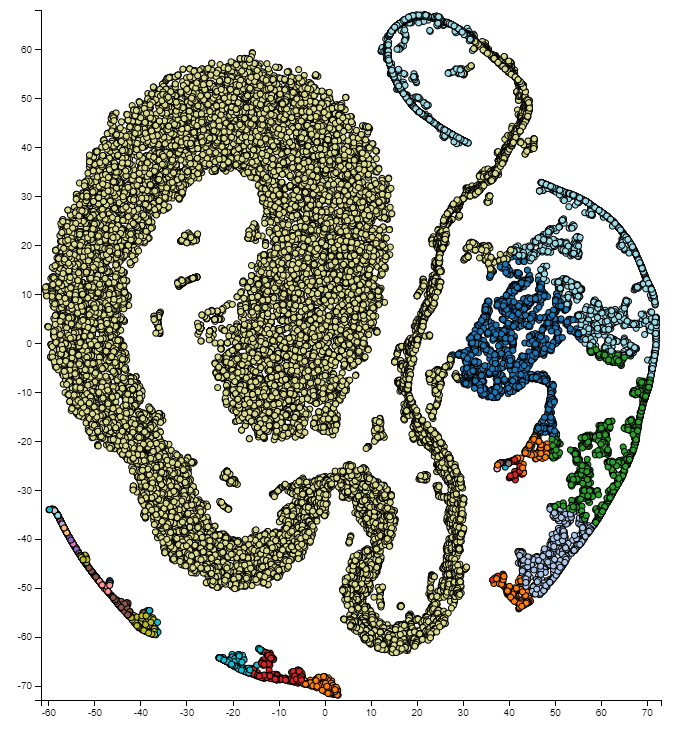

In [ ]:
Image('steamk=50.png')

I think the clustering with k=50 had greater success in delineating more clusters, but I don't want the number of clusters to be too high because it's possible we could have some clusters that have fewer than 5 games in them, which would make it difficult to generate recommendations.

# 4. Building the Recommendation System

To make use of the DataFrames since the necessary information is already stored in them, my recommendation system will be very simple: I'll just add on the cluster labels, build a function that takes in the given name (simply searching by the input phrase), find other titles in the same cluster, and return a few of them.

I've decided to create the function using the k = 23 clustering, since the k = 50 clustering might've been too specific as I mentioned earlier.

In [ ]:
recommendations_df = steam.copy()
recommendations_df['Cluster'] = cluster_labels
recommendations_df.head()

,name,english,median_playtime,1980s,1990's,2.5D,2D,2D Fighter,360 Video,3D,3D Platformer,3D Vision,4 Player Local,4X,6DOF,Abstract,Accounting,Action,Action RPG,Action-Adventure,Adventure,Agriculture,Aliens,Alternate History,America,Animation & Modeling,Anime,Arcade,Arena Shooter,Assassin,Atmospheric,Audio Production,BMX,Base-Building,Baseball,Basketball,Batman,Battle Royale,Beat 'em up,Beautiful,...,Turn-Based,Turn-Based Combat,Turn-Based Strategy,Turn-Based Tactics,Tutorial,Twin Stick Shooter,Typing,Underwater,Utilities,VR,VR Only,VR Support,Valve Anti-Cheat enabled,Vampire,Video Production,Villain Protagonist,Violent,Visual Novel,Voice Control,Voxel,Walking Simulator,War,Wargame,Warhammer 40K,Web Publishing,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,e-sports,linux,mac,windows,approval_rating,total_ratings,age,Cluster
0,Counter-Strike,1,317,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0.973888,127873,21.0,15
1,Team Fortress Classic,1,62,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0.839787,3951,22.0,21
2,Day of Defeat,1,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0.895648,3814,18.0,21
3,Deathmatch Classic,1,184,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0.826623,1540,20.0,21
4,Half-Life: Opposing Force,1,415,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0.947996,5538,22.0,12


In [ ]:
#for the sake of making function output look nice :)
import warnings
warnings.filterwarnings('ignore')

def get_recommendation(title):
  cluster = recommendations_df[recommendations_df['name'] == title]['Cluster'].values[0]
  other_titles = recommendations_df[recommendations_df['Cluster'] == cluster][recommendations_df['name'] != title].head()['name'].values
  print('You wanted titles similar to:', title)
  print('From our Steam database, we recommend: ', other_titles)
  print('Happy gaming!')

# 5. Discussion and Reflection

In [ ]:
get_recommendation('Counter-Strike')

You wanted titles similar to: Counter-Strike
From our Steam database, we recommend:  ['Portal 2' "Sid Meier's Civilization® V" 'Borderlands 2' 'Fallout 4']
Happy gaming!


In [ ]:
get_recommendation('Portal')

You wanted titles similar to: Portal
From our Steam database, we recommend:  ['Killing Floor' 'Grand Theft Auto IV' 'Saints Row: The Third'
 'Castle Crashers®' 'Saints Row IV']
Happy gaming!


In [ ]:
get_recommendation('Fallout 3')

You wanted titles similar to: Fallout 3
From our Steam database, we recommend:  ['Counter-Strike: Condition Zero' 'Day of Defeat: Source'
 'Half-Life 2: Episode Two' 'S.T.A.L.K.E.R.: Shadow of Chernobyl'
 'Total War: MEDIEVAL II – Definitive Edition']
Happy gaming!


Just from looking at these few examples, I think the clustering is fairly useful -- from my own experience, these are games that are pretty similar, so I think the recommendation system works to some extent.

**Improvements that could be made:**
*   incorporating the game's description as a feature through vectorization, like Sue's idea (using word2vec) -- especially since her results were quite good!
*   weighting certain features more highly than others, e.g. weighting game descriptor tags more highly than game age since the genre tends to matter more than the release date
*   developing some kind of within-cluster similarity metric so that my recommendation system would return the most similar titles within the cluster -- this would've been especially helpful for cluster 0, which contains probably at least 60% of the titles

My implementation is certainly not ready to be used in the real world yet -- ideally, I'd like to incorporate all of these improvements, and then it would hopefully return the same results as Steam's own recommendation system. Additionally, I attempted to make the function a little more robust by simply searching within the DataFrame for the title, but due to limitations with string subsearches, doing so didn't return the desired results most of the time. I'd like to refine the search function to search for similar phrases rather than the exact title including punctuation, but that's more software engineering than data science.